In [14]:
import numpy as np
import pandas as pd
import tensorflow as tf
tf.config.run_functions_eagerly(True)
from matplotlib import pyplot as plt
from skimage import exposure
from PIL import Image
import os
import cv2
from sklearn.metrics import accuracy_score
import shutil
import random
from tensorflow.keras.utils import img_to_array, array_to_img
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
import umap
import seaborn as sns

### Loading the dataset

In [2]:
with open("../1_Fetal_gradcams/manual_annot_CRL_Sagittal.txt", "r") as file:
    # Read the contents of the file
    file_contents = file.read()
lines = file_contents.split('\n')
index = [int(i.split(' ')[0]) for i in lines]
labels = [' '.join(i.split(' ')[1:]) for i in lines]
manual_labels_df = pd.DataFrame()
manual_labels_df['Image ID'] = index
manual_labels_df['label'] = labels

manual_labels_df['label'] = manual_labels_df['label'].apply(lambda x: x.strip())

manual_labels_df = manual_labels_df[manual_labels_df['label'] != 'remove']

num_labels = {'head': 0, 'neck': 1, 'body': 2}

manual_labels_df['encoded_label'] = manual_labels_df['label'].map(num_labels)

y = np.array(manual_labels_df['encoded_label'])

In [3]:
imgs = np.load('../1_Fetal_gradcams/cropped_imgs_fetal_regions.npy')

In [4]:
min_angle = -30
max_angle = 30

def rotate_image(image, angle):
    # Get image center coordinates
    center = (image.shape[1] / 2, image.shape[0] / 2)

    # Perform the rotation
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated_image = cv2.warpAffine(image, rotation_matrix, (image.shape[1], image.shape[0]))

    return rotated_image
rotated_images = []
for img in imgs:
    angle = random.uniform(min_angle, max_angle)
    rotated_img = rotate_image(img, angle)
    rotated_images.append(rotated_img)

rotated_images = np.array(rotated_images)

In [5]:
x = np.concatenate((imgs, rotated_images), axis=0)
y =  np.concatenate((y, y), axis=0)

In [6]:
from sklearn.model_selection import train_test_split as tts
x_train, x_test, y_train, y_test = tts(x, y, test_size=0.2, random_state=42)

### Using transfer learning (no training)

In [7]:
# Resizing the images to 48x48 size 

train_X = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in x_train])
test_X = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in x_test])
train_X.shape, test_X.shape

((288, 48, 48, 3), (72, 48, 48, 3))

In [8]:
# Preprocessing the input
train_X = preprocess_input(train_X)
test_X  = preprocess_input(test_X)

In [9]:
# Parameters:
IMG_WIDTH = 48
IMG_HEIGHT = 48
IMG_DEPTH = 3
BATCH_SIZE = 16

# model:
model = VGG16(weights='imagenet',include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH))
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [10]:
# Extracting features

train_deep_features = model.predict(np.array(train_X), batch_size=BATCH_SIZE, verbose=1)
test_deep_features = model.predict(np.array(test_X), batch_size=BATCH_SIZE, verbose=1)

train_deep_features.shape,test_deep_features.shape

c:\Users\SANKARAN\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


5/5 [==============================] - 1s 138ms/step


((288, 1, 1, 512), (72, 1, 1, 512))

In [12]:
umap_deep = umap.UMAP(n_neighbors=15).fit_transform(test_deep_features.squeeze())

C:\Users\SANKARAN\AppData\Local\Temp\ipykernel_20512\2195027183.py:2: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.scatterplot(x = umap_deep[:,0], y = umap_deep[:,1], hue = y_test, palette = sns.hls_palette(10), legend = 'full');


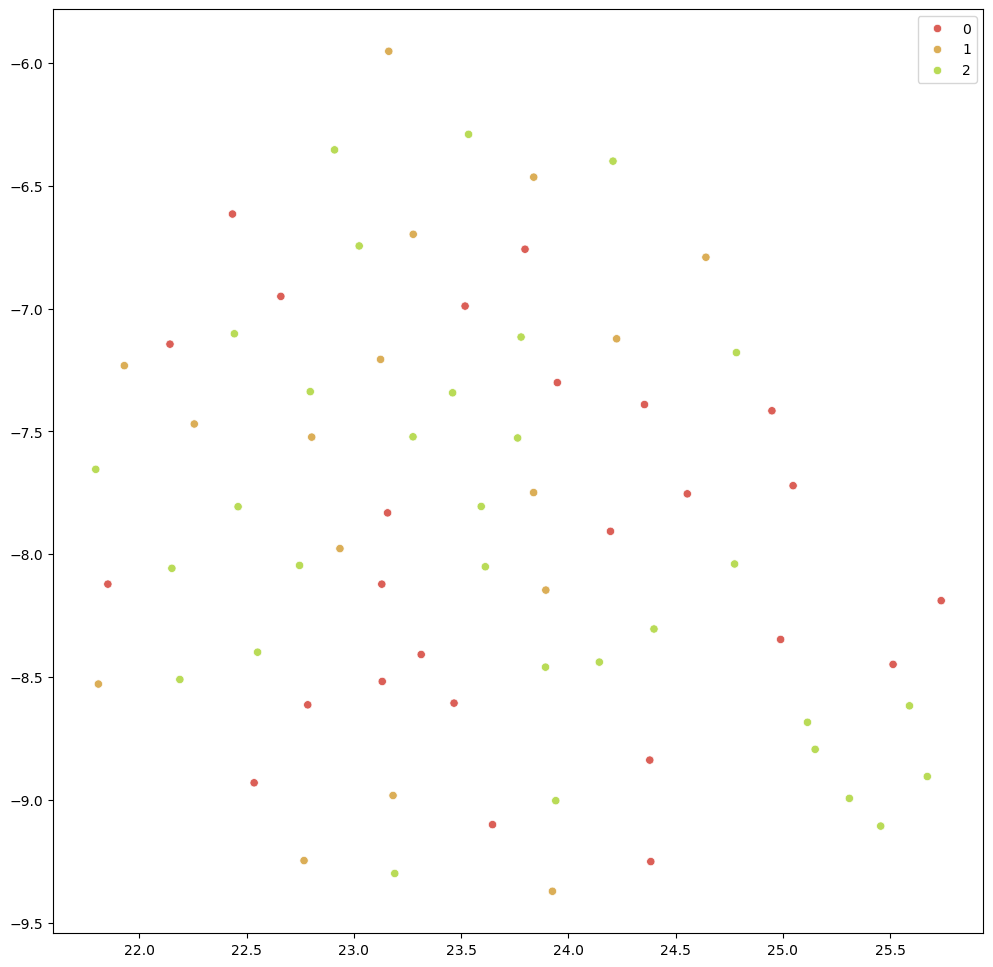

In [15]:
fig = plt.figure(figsize=(12,12))
sns.scatterplot(x = umap_deep[:,0], y = umap_deep[:,1], hue = y_test, palette = sns.hls_palette(10), legend = 'full');

### Classify using transfer learning features 

In [16]:
knn_DL_TL = KNeighborsClassifier(n_neighbors=2) # load the model
knn_DL_TL.fit(train_deep_features.squeeze(),y_train) # fit the model using training data
y_test_pred_DL_TL = knn_DL_TL.predict(test_deep_features.squeeze())

In [17]:
label_names = ['head', 'neck', 'body']

In [18]:
print(classification_report(y_test, y_test_pred_DL_TL, target_names=label_names))

              precision    recall  f1-score   support

        head       0.35      1.00      0.52        25
        neck       0.00      0.00      0.00        16
        body       0.00      0.00      0.00        31

    accuracy                           0.35        72
   macro avg       0.12      0.33      0.17        72
weighted avg       0.12      0.35      0.18        72



c:\Users\SANKARAN\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\SANKARAN\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\SANKARAN\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

### Building a fully trained model

In [19]:
from tensorflow.keras.applications.densenet import DenseNet121
IMG_SIZE = 224
NUM_CLASSES = 3

In [20]:
def build_base_model():

    backbone_model = DenseNet121(
        include_top=False,
        weights="imagenet",
        input_tensor=tf.keras.layers.Input(shape=(IMG_SIZE,IMG_SIZE,3))
    )

    flat = tf.keras.layers.Flatten()(backbone_model.output)
    dense = tf.keras.layers.Dense(256, activation='relu')(flat)
    classifier = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(dense)

    model = tf.keras.models.Model(inputs = backbone_model.input, outputs = classifier)
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(optimizer=optimizer,loss='categorical_crossentropy', metrics = ['accuracy'])

    return model

In [21]:
global_model = build_base_model()

In [22]:
for (i, l) in enumerate(global_model.layers):
    if i <= 426:
        l.trainable = False
    print(i, l.name, l.trainable)

0 input_2 False
1 zero_padding2d False
2 conv1/conv False
3 conv1/bn False
4 conv1/relu False
5 zero_padding2d_1 False
6 pool1 False
7 conv2_block1_0_bn False
8 conv2_block1_0_relu False
9 conv2_block1_1_conv False
10 conv2_block1_1_bn False
11 conv2_block1_1_relu False
12 conv2_block1_2_conv False
13 conv2_block1_concat False
14 conv2_block2_0_bn False
15 conv2_block2_0_relu False
16 conv2_block2_1_conv False
17 conv2_block2_1_bn False
18 conv2_block2_1_relu False
19 conv2_block2_2_conv False
20 conv2_block2_concat False
21 conv2_block3_0_bn False
22 conv2_block3_0_relu False
23 conv2_block3_1_conv False
24 conv2_block3_1_bn False
25 conv2_block3_1_relu False
26 conv2_block3_2_conv False
27 conv2_block3_concat False
28 conv2_block4_0_bn False
29 conv2_block4_0_relu False
30 conv2_block4_1_conv False
31 conv2_block4_1_bn False
32 conv2_block4_1_relu False
33 conv2_block4_2_conv False
34 conv2_block4_concat False
35 conv2_block5_0_bn False
36 conv2_block5_0_relu False
37 conv2_block5_1_

In [23]:
EPOCHS = 50
earlystop = tf.keras.callbacks.EarlyStopping(patience=10)
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=5,
                                            verbose=1,
                                            factor=0.2,
                                            min_lr=1e-6)
mycallbacks = [earlystop, learning_rate_reduction]

In [24]:
y_train_onehot = tf.keras.utils.to_categorical(y_train, num_classes=3)
y_test_onehot = tf.keras.utils.to_categorical(y_test, num_classes=3)

In [25]:
# from scratch
# history = global_model.fit(
#     x_train,
#     y_train_onehot,
#     epochs=EPOCHS,
#     validation_data=(x_test, y_test_onehot),
#     callbacks=mycallbacks,
# )

In [26]:
from tensorflow.keras.models import load_model
global_model = load_model('full_model_fetal_classifier.h5', compile = False)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
global_model.compile(optimizer=optimizer,loss='categorical_crossentropy', metrics = ['accuracy'])

In [27]:
score = global_model.evaluate(x_test, y_test_onehot, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

c:\Users\SANKARAN\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Test loss: 0.12552739679813385
Test accuracy: 0.9583333134651184


In [28]:
# Full dataset
y_onehot = tf.keras.utils.to_categorical(y, num_classes=3)

In [29]:
score = global_model.evaluate(x, y_onehot, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.05855399742722511
Test accuracy: 0.9777777791023254


## Extracting the features

In [30]:
global_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

In [31]:
from tensorflow.keras.models import Model

base_model = global_model

model_FE = Model(inputs=base_model.input, outputs=base_model.get_layer('dense').output)
model_FE.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                            

 conv2_block1_1_relu (Activatio  (None, 56, 56, 128)  0          ['conv2_block1_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block1_2_conv (Conv2D)   (None, 56, 56, 32)   36864       ['conv2_block1_1_relu[0][0]']    
                                                                                                  
 conv2_block1_concat (Concatena  (None, 56, 56, 96)  0           ['pool1[0][0]',                  
 te)                                                              'conv2_block1_2_conv[0][0]']    
                                                                                                  
 conv2_block2_0_bn (BatchNormal  (None, 56, 56, 96)  384         ['conv2_block1_concat[0][0]']    
 ization)                                                                                         
          

In [50]:
df_full = model_FE.predict(x) # extract Deep trained features for the testing subset

c:\Users\SANKARAN\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


12/12 [==============================] - 3s 220ms/step


In [51]:
df_full.squeeze().shape

(360, 256)

In [52]:
# !pip install umap-learn

In [53]:
umap_df = umap.UMAP(n_neighbors=5).fit_transform(df_full)

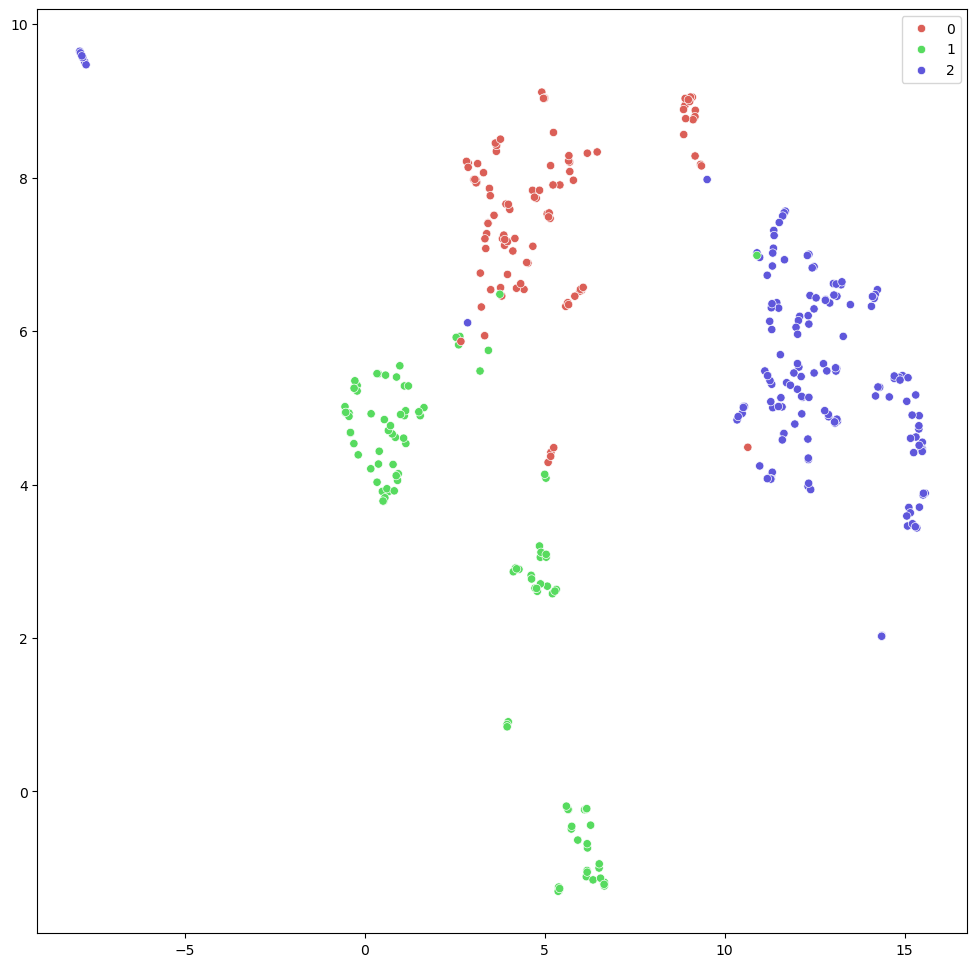

In [54]:
import seaborn as sns
fig = plt.figure(figsize=(12,12))
sns.scatterplot(x = umap_df[:,0], y = umap_df[:,1], hue = y, palette = sns.hls_palette(3), legend = 'full');

In [55]:
from sklearn.neighbors import KNeighborsClassifier
import pickle

# extract features from the training subset:
df_train = model_FE.predict(x)
knn_DL = KNeighborsClassifier(n_neighbors=2) # load the model
knn_DL.fit(df_train,y) # fit the model using training data
y_full_pred_DL = knn_DL.predict(df_full) # model prediction of test data

c:\Users\SANKARAN\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


12/12 [==============================] - 3s 225ms/step


In [56]:
from sklearn.metrics import confusion_matrix

Text(0.5, 1.0, 'KNN trained DL features classification')

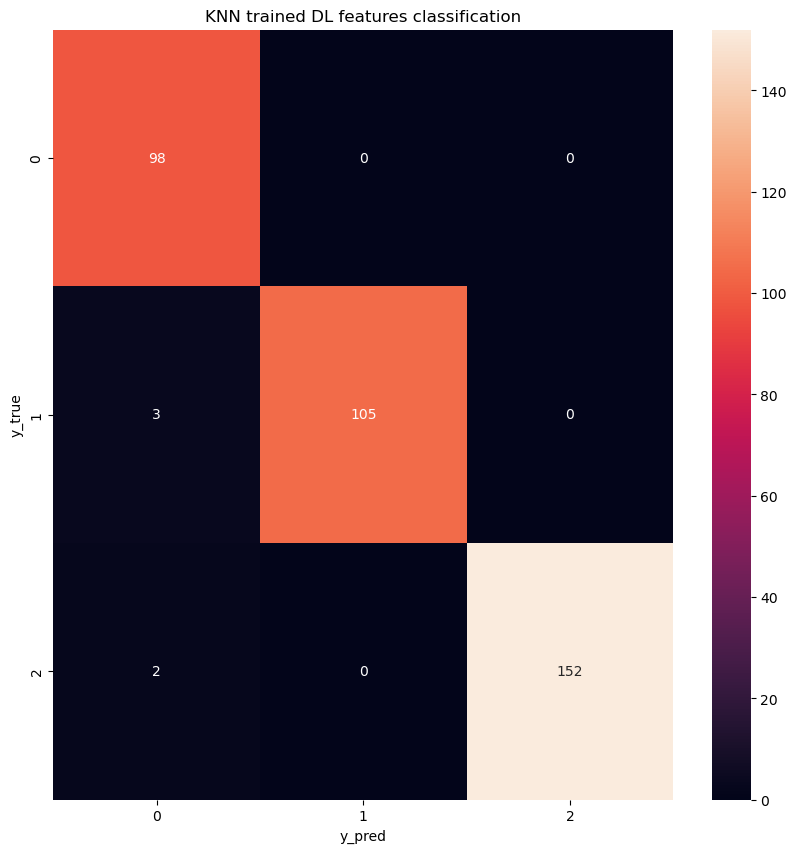

In [57]:
cm_DL = confusion_matrix(y, y_full_pred_DL)

fig = plt.figure(figsize=(10, 10))

sns.heatmap(cm_DL,annot = True,fmt = ".0f")
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.title('KNN trained DL features classification')